# K-Means and FCM Clustering

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets 
from scipy import spatial
from scipy.spatial.distance import cdist

%matplotlib inline 

def KMeans(X, C):
	MaxIter     = 10000;
	StopThresh  = 1e-5;

	#Initialize Cluster Centers by drawing Randomly from Data (can use other
	# methods for initialization...)
	N       = X.shape[0] #number of data points
	d       = X.shape[1] #dimensionality
	rp      = np.random.permutation(N); #random permutation of numbers 1:N
	centers = X[rp[0:C],:]; #select first M data points sorted according to rp

	diff    = 1e100;
	iter    = 0;
	while((diff > StopThresh) & (iter < MaxIter)):
	    #Assign data to closest cluster representative (using Euclidean distance)
	    D   = spatial.distance.cdist(X, centers)
	    L   = np.argmin(D, axis=1)
	    
	    #Update cluster centers
	    centersPrev = centers.copy()
	    for i in range(C):
	    	centers[i,:] = np.mean(X[L == i,:], axis=0)

	    #Update diff & iteration count for stopping criteria
	    diff = np.linalg.norm(centersPrev - centers)
	    iter = iter+1
	return centers, L

# Some code from Author: Phil Roth <mr.phil.roth@gmail.com>
# License: BSD 3 clause

In [10]:
plt.figure(figsize=(12, 12))

n_samples = 1500
noisy_circles, y_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons, y_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs, y_blobs = datasets.make_blobs(n_samples=n_samples)

# Incorrect number of clusters
X = noisycircles
y = y_circles
n_clusters = 3
centers, L = KMeans(X,n_clusters)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=L)
plt.title("Original Blobs")

# Anisotropicly distributed data
transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
centers, L = KMeans(X_aniso,n_clusters)
plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=L)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = datasets.make_blobs(n_samples=n_samples,cluster_std=[1.0, 2.5, 0.5])
centers, L = KMeans(X_varied,n_clusters)
plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=L)
plt.title("Unequal Variance - Only Blobs")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
centers, L = KMeans(X_filtered,n_clusters)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=L)
plt.title("Unevenly Sized Blobs")
plt.show()
    

NameError: name 'noisycircles' is not defined

In [13]:
def _cmeans0(data, u_old, c, m):
    """
    Single step in generic fuzzy c-means clustering algorithm.
    Modified from Ross, Fuzzy Logic w/Engineering Applications (2010),
    pages 352-353, equations 10.28 - 10.35.
    Parameters inherited from cmeans()
    Code from: https://github.com/scikit-fuzzy/scikit-fuzzy/blob/master/skfuzzy/cluster/_cmeans.py
    """
    # Normalizing, then eliminating any potential zero values.
    u_old /= np.ones((c, 1)).dot(np.atleast_2d(u_old.sum(axis=0)))
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m

    # Calculate cluster centers
    data = data.T
    cntr = um.dot(data) / (np.ones((data.shape[1],
                                    1)).dot(np.atleast_2d(um.sum(axis=1))).T)

    d = _distance(data, cntr)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = d ** (- 2. / (m - 1))
    u /= np.ones((c, 1)).dot(np.atleast_2d(u.sum(axis=0)))

    return cntr, u, jm, d

def _distance(data, centers):
    """
    Euclidean distance from each point to each cluster center.
    Parameters
    ----------
    data : 2d array (N x Q)
        Data to be analyzed. There are N data points.
    centers : 2d array (C x Q)
        Cluster centers. There are C clusters, with Q features.
    Returns
    -------
    dist : 2d array (C x N)
        Euclidean distance from each point, to each cluster center.
    See Also
    --------
    scipy.spatial.distance.cdist
    """
    return cdist(data, centers).T


def _fp_coeff(u):
    """
    Fuzzy partition coefficient `fpc` relative to fuzzy c-partitioned
    matrix `u`. Measures 'fuzziness' in partitioned clustering.
    Parameters
    ----------
    u : 2d array (C, N)
        Fuzzy c-partitioned matrix; N = number of data points and C = number
        of clusters.
    Returns
    -------
    fpc : float
        Fuzzy partition coefficient.
    """
    n = u.shape[1]

    return np.trace(u.dot(u.T)) / float(n)


def cmeans(data, c, m=2, error=1e-3, maxiter=300, init=None, seed=None):
    """
    Fuzzy c-means clustering algorithm [1].
    Parameters
    ----------
    data : 2d array, size (S, N)
        Data to be clustered.  N is the number of data sets; S is the number
        of features within each sample vector.
    c : int
        Desired number of clusters or classes.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.
    Returns
    -------
    cntr : 2d array, size (S, c)
        Cluster centers.  Data for each center along each feature provided
        for every cluster (of the `c` requested clusters).
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.
    Notes
    -----
    The algorithm implemented is from Ross et al. [1]_.
    Fuzzy C-Means has a known problem with high dimensionality datasets, where
    the majority of cluster centers are pulled into the overall center of
    gravity. If you are clustering data with very high dimensionality and
    encounter this issue, another clustering method may be required. For more
    information and the theory behind this, see Winkler et al. [2]_.
    References
    ----------
    .. [1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.
    .. [2] Winkler, R., Klawonn, F., & Kruse, R. Fuzzy c-means in high
           dimensional spaces. 2012. Contemporary Theory and Pragmatic
           Approaches in Fuzzy Computing Utilization, 1.
    """
    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = data.shape[1]
        u0 = np.random.rand(c, n)
        u0 /= np.ones(
            (c, 1)).dot(np.atleast_2d(u0.sum(axis=0))).astype(np.float64)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [cntr, u, Jjm, d] = _cmeans0(data, u2, c, m)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return cntr, u  

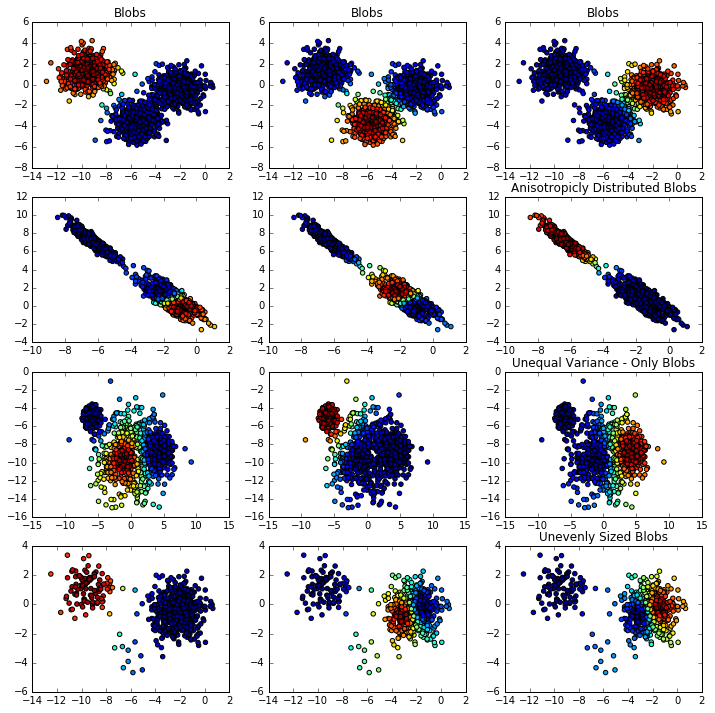

In [15]:
plt.figure(figsize=(12, 12))

n_samples = 1500
noisy_circles, y_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons, y_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs, y_blobs = datasets.make_blobs(n_samples=n_samples)

# Incorrect number of clusters
X = blobs
y = y_blobs
n_clusters = 3
m = 2
centers, L = cmeans(X.T, n_clusters, m)
plt.subplot(431)
plt.scatter(X[:, 0], X[:, 1], c=L[0,:])
plt.title("Blobs")
plt.subplot(432)
plt.scatter(X[:, 0], X[:, 1], c=L[1,:])
plt.title("Blobs")
plt.subplot(433)
plt.scatter(X[:, 0], X[:, 1], c=L[2,:])
plt.title("Blobs")

# Anisotropicly distributed data
transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
centers, L = cmeans(X_aniso.T, n_clusters,m)
plt.subplot(434)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=L[0,:])
plt.subplot(435)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=L[1,:])
plt.subplot(436)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=L[2,:])
plt.title("Anisotropicly Distributed Blobs")


# Different variance
X_varied, y_varied = datasets.make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5])
centers, L = cmeans(X_varied.T, n_clusters,m)
plt.subplot(437)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=L[0,:])
plt.subplot(438)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=L[1,:])
plt.subplot(439)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=L[2,:])
plt.title("Unequal Variance - Only Blobs")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
centers, L = cmeans(X_filtered.T, n_clusters,m)
plt.subplot(4,3,10)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=L[0,:])
plt.subplot(4,3,11)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=L[1,:])
plt.subplot(4,3,12)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=L[2,:])
plt.title("Unevenly Sized Blobs")

plt.show()